<a href="https://colab.research.google.com/github/KamilBartosik/CNN_TrafficSignClassification/blob/main/CNN_TrafficSignClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamilbartosik","key":"60a7bc4864ce8f6cc1ed6c5660f37473"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


In [5]:
!kaggle datasets list -s gtsrb-german-traffic-sign

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34          66220        880  0.8235294        
valentynsichkar/traffic-signs-preprocessed                         Traffic Signs Preprocessed                           4GB  2019-08-31 18:22:11           8793        232  1.0              
eunjurho/german-traffic-sign-recognition-benchmark-cropped         german_traffic_sign_recognition_benchmark_cropped  206MB  2019-11-10 15:22:13            313          8  0.75             
bhavinmoriya/german-traffic-sign-recognition-bench

In [6]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
%cd ..

 96% 590M/612M [00:10<00:00, 42.2MB/s]
100% 612M/612M [00:10<00:00, 61.1MB/s]
/content


In [ ]:
!unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset
!rm traffic_sign_dataset/gtsrb-german-traffic-sign.zip

In [8]:
!rm -rf traffic_sign_dataset/Meta
!rm -rf traffic_sign_dataset/meta
!rm -rf traffic_sign_dataset/test
!rm -rf traffic_sign_dataset/train
!rm traffic_sign_dataset/Meta.csv

# Importing libraries

In [10]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split

# Image preprocessing

## Check data and dimensions of images

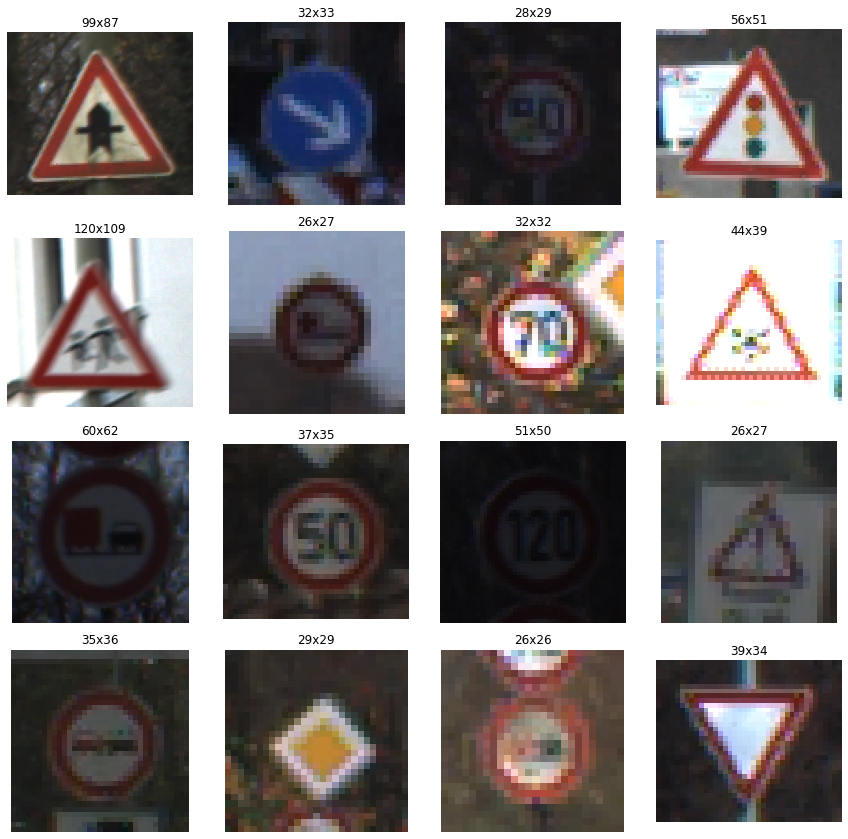

In [18]:
plt.figure(figsize=(12, 12))
path = "traffic_sign_dataset/Test"
for i in range(1, 17):
  plt.subplot(4, 4, i)
  plt.tight_layout()
  rand_img = imread(path + '/' + random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.axis('off')
  plt.title(f'{rand_img.shape[1]}x{rand_img.shape[0]}' )

In [30]:
# Check mean dimension of images
dim1 = []
dim2 = []

path_trainset = "traffic_sign_dataset/Train"
nb_classes = len(os.listdir(path_trainset))

for class_nb in range(nb_classes):
  labels = f"traffic_sign_dataset/Train/{class_nb}"
  img_path = os.listdir(labels)
  for image_nb in img_path:
    img = imread(labels + '/' + image_nb)
    dim1.append(img.shape[0])
    dim2.append(img.shape[1])

In [31]:
print("Mean dimension of images: ", np.around(np.mean(dim1), 1), "x", np.around(np.mean(dim2), 1))

Mean dimension of images:  50.3 x 50.8


## Image resize and normalization

In [42]:
images = []
label_id = []

for class_nb in range(nb_classes):
  labels = f"traffic_sign_dataset/Train/{class_nb}"
  img_path = os.listdir(labels)
  for image_nb in img_path:
    img = Image.open(labels + '/' + image_nb)
    img = img.resize((50, 50))
    img = np.array(img)
    images.append(img)
    label_id.append(class_nb)

In [43]:
images = np.array(images)
images = images/255
images.shape

(39209, 50, 50, 3)

In [44]:
label_id = np.array(label_id)
label_id.shape

(39209,)

## Preparing Train and Val sets

In [47]:
x_train, x_val, y_train, y_val = train_test_split(images, label_id, test_size = 0.2, random_state = 42)

In [48]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)